In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import numpy as np

## 1. importing and filtering data
After importing the needed packages, it's needed to import the data and filter only the wanted datapoints.

The chosen subject was S26: a  20 years old, right-handed and naive female.

In [98]:
# Read the data from the file

# Specify the file path
file_path = './Project2-data/S26.mat'

# Load the data from the file
dataset = scipy.io.loadmat(file_path)

In [99]:
# Filtering only the needed data:
# channel: 61 (Oz)
# time: 125 to 1375 (removing the pre and post-stimulus)
# frequencies: 2 and 7, equivalent for 10 and 15 Hz

# Convert the data to a pandas dataframe
data = dataset.get('data')
print(type(data))
print(data.shape)

filtered_data = data[61, 125:-125, [2, 7]]
print(filtered_data.shape) # 1250 timesteps for each of the 6 blocks for each of the frequencies

<class 'numpy.ndarray'>
(64, 1500, 40, 6)
(2, 1250, 6)


## 2. Reorganizing the data

In [104]:
reorganized_data = np.array(
    [filtered_data[j, :, i] for j in range(2) for i in range(6)]
    )
target_data = np.array([j for j in range(1, -2, -2) for i in range(6)])

## 3. Implementing and training the perceptron

In [105]:
# defining an auxiliary function to split the data
import random

def split_data(data, target):
    """
    Split the data into training and validation sets.
    
    Parameters:
    data: the data to be split
    target: the target data to be split
    train_size: the size of the training set
    """

    rand = random.sample(range(6), 4)
    trainX = reorganized_data[[k for k in range(12) if k%6 in rand]]
    trainY = target_data[[k for k in range(12) if k%6 in rand]]
    valX = reorganized_data[[k for k in range(12) if k%6 not in rand]]
    valY = target_data[[k for k in range(12) if k%6 not in rand]]
    
    return trainX, trainY, valX, valY

In [106]:
# the base perceptron itself is already implemented on this other file
from perceptron import Perceptron

def train(rate, epochs):
    p = Perceptron(reorganized_data.shape[1])

    trainX, trainY, valX, valY = split_data(reorganized_data, target_data)
    
    # training the perceptron
    p.train(trainX, trainY, learning_rate=rate, max_epochs=epochs)
    t = p.success_rate(trainX, trainY)

    # evaluating its performance on the validation set
    v = p.success_rate(valX, valY)
    
    return t, v

# testing the perceptron
train(0.04, 500)

(1.0, 0.75)

## 4. Testing initial params

It's crystal clear that the initial weights should not be initialized anyway different than randomly, so it does not generate an unwanted bias on the dataset.

For the learning rate and number of epochs run, here is a simulation that calculates that iterates over 10 possibilities for each, and plot its perfomance on a heatmap:

In [107]:
# warning: takes long to train

arr = np.ndarray((2, 5, 5))

for i in range(arr.shape[1]):
    for j in range(arr.shape[2]):
        t, v = 0, 0
        for k in range(50):
            # initializing a new perceptron
            p_i = Perceptron(reorganized_data.shape[1])

            # training the perceptron and getting its success rates
            res = train(0.06*j, 200*i)

            t += res[0]
            v += res[1]

        arr[0][i][j], arr[1][i][j] = t/50, v/50


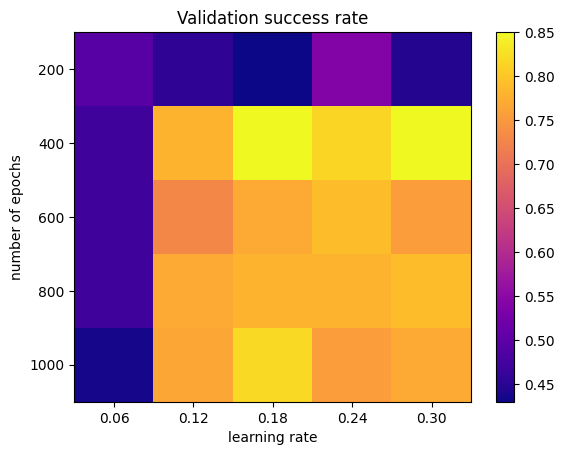

In [108]:
# plotting the results
plt.imshow(arr[1], cmap='plasma', interpolation='none', extent=[0.03, 0.33, 1100, 100], aspect='auto')
plt.colorbar()

plt.xlabel('learning rate')
plt.xticks(np.arange(0.06, 0.31, 0.06))
plt.ylabel('number of epochs')
plt.yticks(np.arange(200, 1100, 200))
plt.title('Validation success rate')
plt.show()

It seems that even variating widely the range of possible values, there are no optimal values to train this perceptron to separate the data. It seems that the dataset, probably, is not quite linearly separable.

This gets visually more visible when we consider the time series plot on section 2.

## 6. Confusion matrix

In [113]:
import seaborn as sns

mat = np.zeros((2,2))

# choosing the best learning rate and number of epochs (0.18 and 400 respectively) from the above tests
# and training a new perceptron again through 100 iterations to get a better estimate of the success rate:

for i in range(300):
    p2 = Perceptron(reorganized_data.shape[1])
    # generating the training and validation sets
    trainX, trainY, valX, valY = split_data(reorganized_data, target_data)

    # training the perceptron
    p2.train(trainX, trainY, learning_rate=0.18, max_epochs=400)

    # evaluating its performance on the validation set
    for i in range(2):
        if(p2.eval(valX[i]) == valY[i]):
            mat[0, 0] += 1
        else:
            mat[1, 0] += 1

    for i in range(2, 4):
        if(p2.eval(valX[i]) == valY[i]):
            mat[1, 1] += 1
        else:
            mat[0, 1] += 1

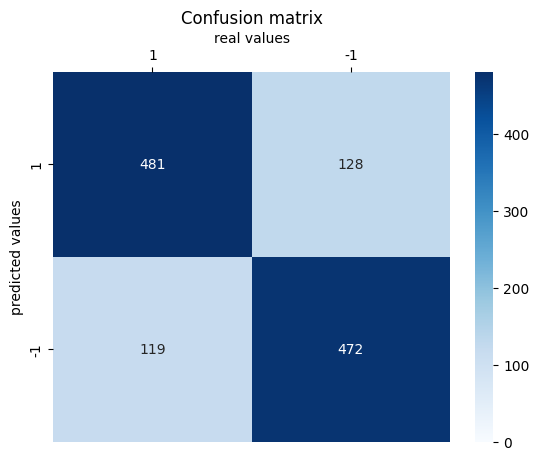

In [114]:
ax = sns.heatmap(mat, annot=True, fmt='g', cmap='Blues', vmin=0)
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
plt.xlabel('real values')
plt.xticks([0.5, 1.5], ['1', '-1'])
plt.ylabel('predicted values')
plt.yticks([0.5, 1.5], ['1', '-1'])
plt.title('Confusion matrix')
plt.show()

As conjectured, the perceptron was not able to separate the data. The confusion matrix shows that there was some level of accuracy (77.4%), but it was not even close to a good separation.

## 7. Analyzing through FFT's

So, as seen on the examples before, the data is not linearly separable. Let's try to analyze it, then, through the composing frequencies of the data.

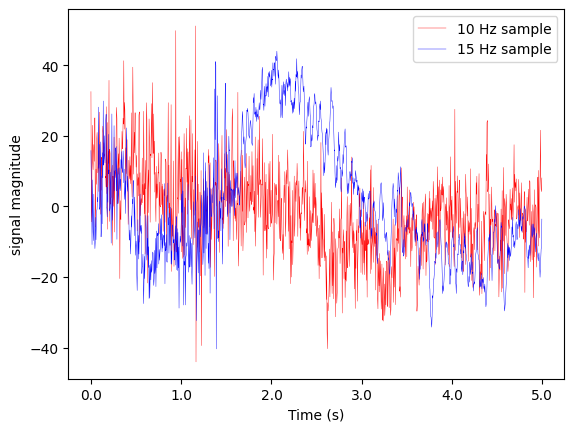

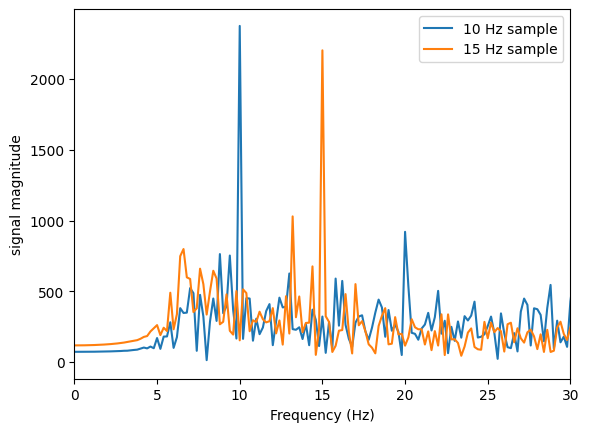

In [118]:
import scipy.signal

# defining a bandpass filter
def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data

# choosing one sample for each frequency to plot
sample_0 = reorganized_data[2] # 10 Hz
sample_1 = reorganized_data[7] # 15 Hz

# plotting the time series
plt.plot(sample_0, color='red', linewidth=0.3)
plt.plot(sample_1, color='blue', linewidth=0.3)
plt.xlabel("Time (s)")
plt.ylabel("signal magnitude")
plt.xticks(np.arange(0, 1251, 250), np.arange(0, 5.1, 1))
plt.legend(['10 Hz sample', '15 Hz sample'])
plt.show()

# getting the frequency spectrum for the fft's, filtering the data for frequencies between 6 and 70 Hz
a = np.abs(np.fft.fft(bandpass(sample_0, [6, 70], 250)))
b = np.abs(np.fft.fft(bandpass(sample_1, [6, 70], 250)))

# plotting the frequency spectrum
f = np.linspace(0, 250, 1250, endpoint=False)
plt.plot(f, a)
plt.plot(f, b)
plt.xlim(0, 30) 
plt.xticks(np.arange(0, 35, 5))
plt.xlabel("Frequency (Hz)")
plt.ylabel("signal magnitude")
plt.legend(['10 Hz sample', '15 Hz sample'])
plt.show()

Even by varying the input, the main frequencies still appear visible and on the approximate same places, giving us a hint that could be used for the class separation.

## 8. Implementing and training the perceptron with FFT

The idea behind this model is to use the FFT to transform the data into the frequency domain, getting the main frequencies of the data, and then use these frequencies to train the perceptron.

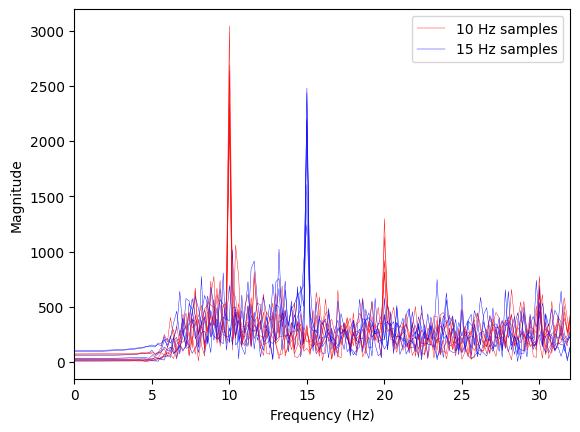

[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]


In [119]:
# transforming the data to the frequency domain

# filtering the data for frequencies between 6 and 70 Hz
freq_data = [np.abs(np.fft.fft(bandpass(reorganized_data[i], [7, 75], 250))) for i in range(12)]

# plotting the frequency spectrum for each sample
for i in range(6):
    plt.plot(f, freq_data[i], color='red', linewidth=0.3)
    plt.plot(f, freq_data[i+6], color='blue', linewidth=0.3)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 32)
plt.legend(["10 Hz samples", "15 Hz samples"])
plt.show()

# getting only the main frequencies (considering only the first half freqs)
max_freq_indices = [np.argmax(data[:750]) for data in freq_data]
max_freqs = [f[index] for index in max_freq_indices]
print(max_freqs)

Without even using the perceptron, it's seems that the model was able to steadily extract a very usable feature: the desired frequency itself. All of this without needing to train a perceptron, and with an accuracy of 100%.